<a href="https://colab.research.google.com/github/Kirteeraj/Pneomina-Dectation-using-X-ray/blob/main/Dense201-acc-80-1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
! pip install -q kaggle

In [ ]:
 ! mkdir ~/.kaggle

In [40]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"kirteeraj","key":"ebe4a9e772c807dd21e116caf8edb7e9"}'}

In [41]:
! cp kaggle.json ~/.kaggle/

In [ ]:
 ! chmod 600 ~/.kaggle/kaggle.json

In [42]:
! kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              237KB  2021-11-02 21:56:08          15251  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           9286  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           4141  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   2GB  2021-10-22 10:48:21           3400  
promptcloud/careerbuilder-job-listing-2020                  Careerbuilder Jo

In [43]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
! unzip chest-xray-pneumonia.zip

In [44]:
!pwd

/content


In [77]:
import tensorflow
import pandas as pd
import numpy as np
import os
import keras
from tensorflow.keras.applications import DenseNet169, DenseNet121, MobileNet, DenseNet201
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

import matplotlib.pyplot as plt

In [78]:
base_model = DenseNet201(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3)
)
base_model.summary()

Model: "densenet201"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_8 (ZeroPadding2  (None, 230, 230, 3)  0          ['input_5[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d_8[0][0]']       
                                )                                                       

In [79]:
training_dir='./chest_xray/train/'
validation_dir='./chest_xray/val/'
test_dir='./chest_xray/test/'

In [80]:
test_ds = image_dataset_from_directory(
    directory=test_dir,
    labels='inferred',
    label_mode='binary',
    batch_size=16,
    image_size=(224, 224),
    )

Found 624 files belonging to 2 classes.


In [81]:
train_ds = image_dataset_from_directory(
    directory=training_dir,
    shuffle=True,
    labels='inferred',
    label_mode='binary',
    batch_size=16,
    image_size=(224, 224),
    )

Found 5216 files belonging to 2 classes.


In [82]:
validation_ds = image_dataset_from_directory(
    directory=validation_dir,
    labels='inferred',
    label_mode='binary',
    batch_size=16,
    image_size=(224, 224),
    )

Found 16 files belonging to 2 classes.


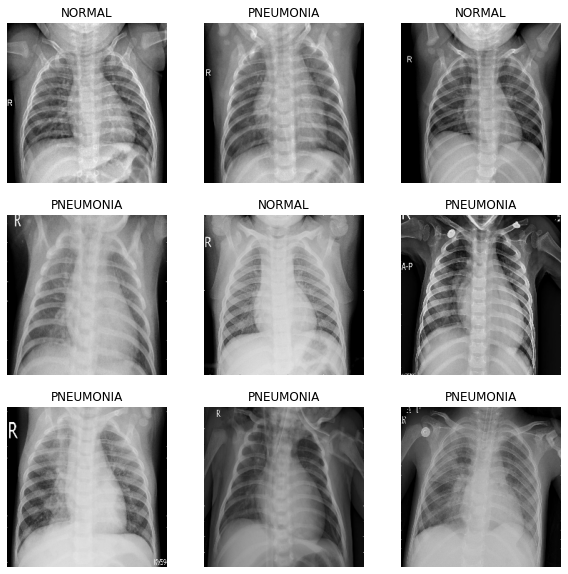

In [83]:
# data visulazation
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[int(labels[i])])
    plt.axis("off")

In [84]:
data_augmentation = tensorflow.keras.Sequential([
  tensorflow.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tensorflow.keras.layers.experimental.preprocessing.RandomRotation(0.1),
])

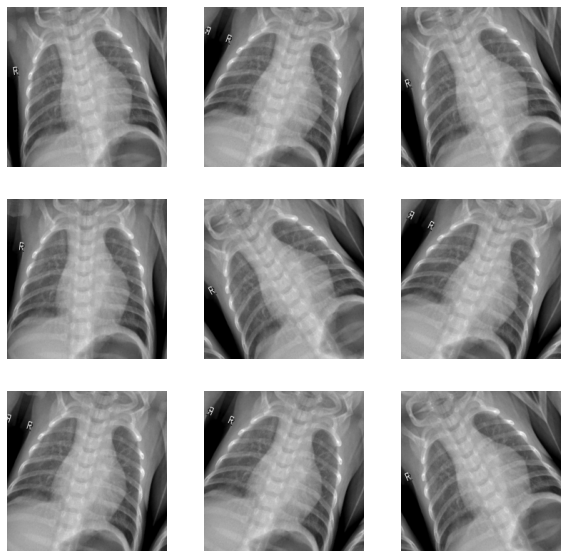

In [85]:
# data visulation for augmentation
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tensorflow.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [86]:
test_ds

<BatchDataset shapes: ((None, 224, 224, 3), (None, 1)), types: (tf.float32, tf.float32)>

In [87]:
x=base_model.output

x= data_augmentation(x)
x= GlobalAveragePooling2D()(x)
x= BatchNormalization()(x)
x= Dropout(0.6)(x)
# x= Dense(1024,activation='relu')(x) 
x= Dense(512,kernel_regularizer=regularizers.l2(0.0001), activation='relu')(x) 
x= BatchNormalization()(x)
x= Dropout(0.6)(x)

preds=Dense(2,activation='softmax')(x)

In [88]:
model=Model(inputs=base_model.input,outputs=preds)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_8 (ZeroPadding2  (None, 230, 230, 3)  0          ['input_5[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d_8[0][0]']       
                                )                                                           

In [89]:
# for layer in model.layers[:-8]:
#     layer.trainable=False

# for layer in model.layers[-8:]:
#     layer.trainable=True

In [90]:
base_model.trainable = False

In [91]:
model.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=1e-4),loss='sparse_categorical_crossentropy',metrics=['accuracy'])


In [92]:
len(model.trainable_variables)

8

In [93]:
initial_epochs = 20

In [94]:
history=model.fit(x=train_ds,
                           validation_data=validation_ds,
                           epochs=initial_epochs,
                           verbose=1)

Epoch 1/20
326/326 [==============================] - 87s 213ms/step - loss: 0.8017 - accuracy: 0.7395 - val_loss: 0.2233 - val_accuracy: 0.9375
Epoch 2/20
326/326 [==============================] - 66s 200ms/step - loss: 0.5305 - accuracy: 0.8422 - val_loss: 0.3027 - val_accuracy: 0.9375
Epoch 3/20
326/326 [==============================] - 66s 200ms/step - loss: 0.4262 - accuracy: 0.8702 - val_loss: 0.4071 - val_accuracy: 0.8125
Epoch 4/20
326/326 [==============================] - 66s 200ms/step - loss: 0.3606 - accuracy: 0.8909 - val_loss: 0.4896 - val_accuracy: 0.8125
Epoch 5/20
326/326 [==============================] - 66s 200ms/step - loss: 0.3470 - accuracy: 0.8934 - val_loss: 0.5901 - val_accuracy: 0.7500
Epoch 6/20
326/326 [==============================] - 66s 200ms/step - loss: 0.3389 - accuracy: 0.8980 - val_loss: 0.6279 - val_accuracy: 0.7500
Epoch 7/20
326/326 [==============================] - 66s 199ms/step - loss: 0.2930 - accuracy: 0.9151 - val_loss: 0.5311 - val_ac

In [95]:
score = model.evaluate(test_ds, verbose = 1) 

39/39 [==============================] - 8s 191ms/step - loss: 0.8260 - accuracy: 0.7548


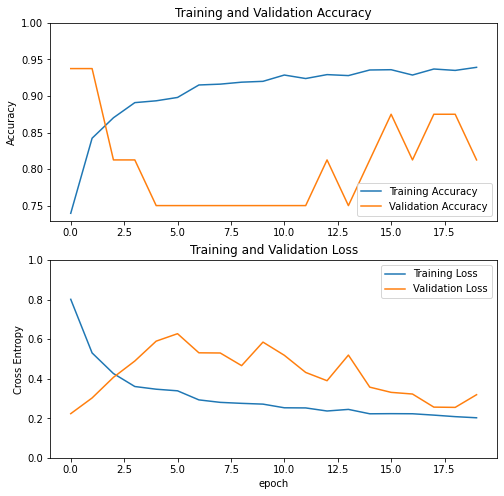

In [96]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [112]:
base_model.trainable = True

In [116]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 650

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  707


In [114]:
model.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=1e-5),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [117]:
len(model.trainable_variables)

56

In [118]:
fine_tune_epochs = 20
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_ds)

Epoch 20/40
326/326 [==============================] - 95s 245ms/step - loss: 0.1337 - accuracy: 0.9688 - val_loss: 0.1603 - val_accuracy: 0.9375
Epoch 21/40
326/326 [==============================] - 77s 233ms/step - loss: 0.1080 - accuracy: 0.9755 - val_loss: 0.1416 - val_accuracy: 0.9375
Epoch 22/40
326/326 [==============================] - 77s 233ms/step - loss: 0.1188 - accuracy: 0.9735 - val_loss: 0.1351 - val_accuracy: 0.9375
Epoch 23/40
326/326 [==============================] - 77s 233ms/step - loss: 0.1138 - accuracy: 0.9747 - val_loss: 0.1250 - val_accuracy: 0.9375
Epoch 24/40
326/326 [==============================] - 77s 233ms/step - loss: 0.1063 - accuracy: 0.9774 - val_loss: 0.1472 - val_accuracy: 0.9375
Epoch 25/40
326/326 [==============================] - 77s 233ms/step - loss: 0.1020 - accuracy: 0.9797 - val_loss: 0.1268 - val_accuracy: 0.9375
Epoch 26/40
326/326 [==============================] - 77s 233ms/step - loss: 0.0958 - accuracy: 0.9812 - val_loss: 0.1176 -

In [119]:
score = model.evaluate(test_ds, verbose = 1) 

39/39 [==============================] - 8s 196ms/step - loss: 0.8645 - accuracy: 0.8061


In [120]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

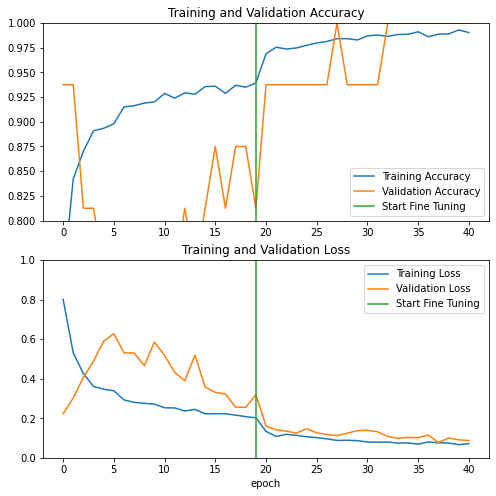

In [121]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
model.save('/')